# Aster Centering Analysis - Day 1
***
<i> Dmitrief, Turlier, De Labbey, Badaoui </i> </br>
<i> ENS - Active Matter  Workshop - Feb 22 </i>

In this notebook, we use Cytosim Analysis to analyze a Simulation where an Aster autonomously moves to the center.

## Imports

In [2]:
#Classic Import

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
import pandas as pd
import sys
import os 

#Cytolysis Import

from cytolysis import cytosim_analysis as ana
from cytolysis.objects import Object, Object_set

import sio_tools as sio


from aster import Aster_set
from methods import distance, colin, total_force, total_individual_forces, tweezer_distance


In [21]:
#PARAMETERS

frame_step = 1

#PATH

from pathlib import Path
current_path = str(Path().absolute()) 
path_simu = current_path  + '/simu'

## <u> Hands on Cytosim </u>

This part has been largely inspired by documentation and tutorials available on [Cytosim's repository](https://gitlab.com/f-nedelec/cytosim/-/tree/master/doc "Cytosim").

### Executables

Cytosim has three main executables:

*   `sim` reads instructions from a config file, usually `config.cym` and runs the simulation.
*   `play` displays an existing simulation. `play live` runs the simulation and displays it simultaneously.
*   `report` exports data to the terminal or to text files.

### Configuration 

An example of config file :

```
set simul system
{
    time_step = 0.01
    viscosity = 0.01
    steric = 1, 200
}

set space cell
{
    shape = circle
}

new cell
{
    radius = 10
}

set bead ball
{
    steric = 1
    confine = inside, 500
}

new 1 bead ball
{
    radius = 1
    position = 1 0
}

run 100 system
{
    nb_frames = 50
}

```

[Config files](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/config.md "Config file documentation") contain a sequence of [commands](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/commands.md "Commands documentations"). The three main commands, that you can see above are :  

* `set` to define an object category
* `new` to create objects
* `run` to perform simulation steps

### Parameters

In Cytosim, [units](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/units.md "Units") are μm, pN, s.

#### Steric interations

One has to set whether steric interactions between objects will be considered or not. The first argument after steric is a boolean (0 for no interactions, 1 for interactions). The second parameter is the steric stiffness. Repulsion is indeed implemented by a [repulsive quadratic potential](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/steric.md "steric").

Confinement works in a similar way: the first argument defines the confinement mode: `inside` confines the center, `all_inside` confines the whole object, `on` to confine on the border... The second parameter is the confinement stiffness.

#### Spaces

One has to give the shape and dimensions. A list of available shapes can be found [here](https://gitlab.com/f-nedelec/cytosim/-/blob/master/doc/sim/spaces.md "Spaces").


#### Objects
Various objects have lots of different parameters. Beads are among the simplest. In the following, more complex objects such as fibers or motor will be considered.


###  Your first simulation

#### System and cell
```
set simul system
{
    time_step = 0.001
    viscosity = 0.01
}

set space cell
{
    shape = sphere
}

new cell
{
    radius = 10
}
```

#### Microtubules

```
set fiber microtubule
{
    rigidity = 25
    segmentation = 0.5
    confine = inside, 500
    
    activity = classic
    growing_speed    = 0.5
    growing_force    = 1.67
    shrinking_speed  = -0.85
    catastrophe_rate = 0.01, 0.04
    rescue_rate      = 0.064
    min_length       = 0.5
    persistent       = 0
 
    display = ( line_width = 4; )
}

new 1 fiber microtubule
{
    length = 5
    plus_end = grow
}

run 10000 system
{
    nb_frames = 100
}
```

**Q0. Follow these steps to run your first simulation**

* Go to `/simu/example_microtubules/`


* Run `../../../bin/sim` or `../../../bin/play live` from the folder.

#### Comments 
Microtubules polymerize until a castrophe happens.   

Stochastic attachment and detachment of monomers are not taken into account in Cytosim. Instead, polymerization is modeled as a constant expansion of the fiber, at the speed `growing_speed`.  

The growth of microtubule generates forces, when stuck against a boundary for example. In return, the growth speed diminishes: `growing_force` is the force for which the polymerization speed reaches zero. It is also the typical force a microtubule exerts because of polymerization.  

The `catastrophe_rate` is higher when microtubules are stalled. The first value is the rate for a free microtubule, the second for a microtubule stuck against a boundary.

Microtubules are deleted when shorter than `min_length`.

### Aster

An aster is an organizer: it links the core, an undeformable solid, to microtubules. Each microtubule is nucleated from the center and linked to the core by two links to prevent it from pivoting. The first stifness is the one at the center.  

``` 
set solid centrosome
{
    display = ( style=3; color=blue; )
    confine = inside, 100, cellule
}

set aster astre
{
    stiffness = 1000, 500
}

new astre
{
    solid = centrosome
    radius = 0.5
    point1 = center, 0.5
    fibers = 50, microtubule, ( length = 2; plus_end = green;)
    position = -6,0
}

``` 

In [4]:
#Photo

## <u>  Aster centering </u>

In this tutorial, we will keep investigating on several mechanisms for aster centerin :

* Pushing of microtubules on the membrane
* Bulk pulling of dyneins carrying vesicles along microtubules
* Cortical pulling of dyneins attached to transmembrane complexes


In [5]:
#Quick Vidéo 

As said before we deal with microtubules that can polymerize until a catastrophe happens :  

Fibers keep growing at a `growing_speed`, which generates a force. When they grow against a boundary the growth speed diminishes : `growing_force` is the force for which the polymerization speed reaches zero.  

The `catastrophe_rate` is higher when microtubules are stalled. The first value is the rate for a free microtubule, the second for a microtubule stuck against a boundary.

## <u> Pushing </u>


### <i> <u> First Part - Position </u> </i>
<i>First We will check the Position of The Aster</i>.

**Q1. Run the simulation with the config file in `/pushing/example_pushing` by using the `sim` command.**:

* `../../../bin/sim ./config.cym `

**Q2. Report the characteristic of the Aster with the `report`:**

* ` ../../../bin/report aster:links > links.txt`
* ` ../../../bin/report aster:force > force.txt`


`links.txt` contains all the information about the position (X,Y) and the force for each link through time.  
`force.txt` contains all the information about the position (X,Y) and the force for applied to the aster through time.

**Q3. Check the files consistency and use the `cytosim_analysis` package to analyze the report files.**

*NB : You should get a Pandas DataFrame summarizing all the important quantitites.*

In [6]:
def cytosim_analysis_function(path_in):
    

    # REPORT FILES

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in + "/links.txt" #Links for the Aster

    #Config
    config_file = path_in + "/config.cym" #Config File

    # DICTIONNARY

    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    # CREATE SIMULATION INSTANCE

    simul = ana.Simulation(solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)

    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force, 
              "total_individual_forces":total_individual_forces} 

    # ANALYSIS

    simul.make_analysis(frame_analyzer=analyzer)
    analysis=simul.frames_analysis
    
    return analysis


In [7]:
folder_test = '/pushing/example_pushing'

df_analysis = cytosim_analysis_function(path_simu + folder_test)
df_analysis
distance_aster = df_analysis['distance']

In [8]:
df_analysis

id  distance     colin         total_force  \
0      0  6.000000  0.986394  [-0.0012, -0.0002]   
1      1  6.095280 -0.595367   [4.0112, -5.2886]   
2      2  6.123934 -0.939487    [1.9247, 0.7163]   
3      3  5.870108  0.878590   [-5.7011, 2.8949]   
4      4  5.449823 -0.603846   [2.8378, -3.4976]   
..   ...       ...       ...                 ...   
296  296  3.321974 -0.999536  [45.1261, 11.3373]   
297  297  3.335569 -0.999998  [44.7163, 11.0614]   
298  298  3.360655 -1.000000   [50.2922, 12.239]   
299  299  3.398767 -0.999593  [52.7423, 11.4138]   
300  300  3.415558 -0.991477  [59.7996, 23.6469]   

                               total_individual_forces  
0    [-0.0011000000000000003, -0.00019999999999999998]  
1                          [4.011, -5.288499999999999]  
2             [1.9247999999999994, 0.7163999999999999]  
3                         [-5.701, 2.8952000000000004]  
4                         [2.838, -3.4975000000000014]  
..                                                 ...  
296            [45.12610000000001, 11.337099999999998]  
297                                 [44.7164, 11.0615]  
298            [50.29230000000001, 12.239099999999999]  
299                      [52.7421, 11.413900000000002]  
300           [59.799699999999994, 23.646799999999995]  

[301 rows x 5 columns]

**Q4. Is the Aster Centering ?**
* **A. Plot the distance to the center with respect to the time and check the stability of it.**
* **B. You can help yourself with the `play` command on Cytosim.**

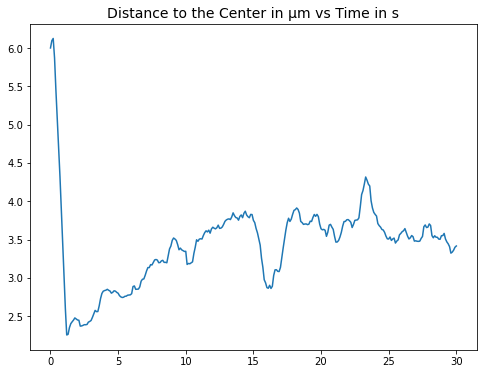

In [9]:
#PLOTS

#Centration of The Aster

plt.figure(figsize =(8,6))

plt.plot(df_analysis["id"]*frame_step,distance_aster,label="Distance to the Center")

plt.title('Distance to the Center in µm vs Time in s',size =14)
plt.show()

* **C. If it is not centering, what do you suggest to permit it ?**

Try to tweak the microtubule parameters, in particular the `catastrophe_rate` :  


``` 
set fiber microtubule
{
    rigidity = 30
    segmentation = 0.5
    confine = inside, 100
    activity       = classic
    

    growing_speed            = 1
    shrinking_speed          = -3
    catastrophe_rate         = 0.1
    catastrophe_rate_stalled = 0.2
    rescue_rate              = 1
    growing_force            = 0.15

    persistent = 1

    display = { line_width=5; }

```

You can tweak the parameters on the `example_centering` file and restart !

<i> <u> Solution </u></i>  

In [10]:
folder_test = '/pushing/example_pushing_centering'

df_analysis = cytosim_analysis_function(path_simu + folder_test)
df_analysis
distance_aster = df_analysis['distance']

In [11]:
#PLOTS

#Centration of The Aster

plt.figure(figsize =(8,6))

plt.plot(df_analysis["id"]*frame_step,distance_aster,label="Distance to the Center")

plt.title('Distance to the Center in µm vs Time in s',size =14)
plt.show()

### <i> <u> Second Part - Force </u></i>
<i>One way to quantify te stability of the Aster Positionning is to measure the force with respect to the position, to conclude whether or not the position is a stable fixed point.
</i>

**Q5. Get a plot of the force, using the same simulation as before**

#### Force along axis

In [12]:
# Force along x axis

plt.figure(figsize =(8,6))

plt.plot(df_analysis["id"]*frame_step,np.array(df_analysis['total_force'].to_list())[:,0],label="Total Force")

plt.title('Force along X axis in pN vs Time in s',size=14)
plt.legend()
plt.show()

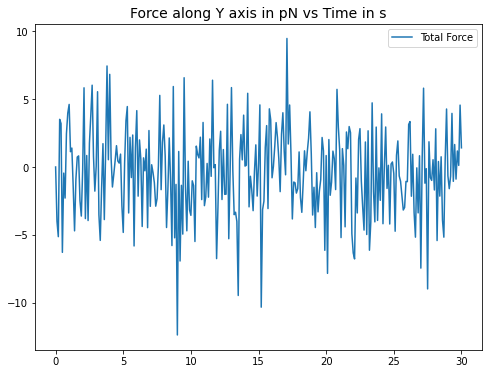

In [13]:
# Force along y axis

plt.figure(figsize =(8,6))

plt.plot(df_analysis["id"]*frame_step,np.array(df_analysis['total_force'].to_list())[:,1],label="Total Force")

plt.title('Force along Y axis in pN vs Time in s',size=14)
plt.legend()
plt.show()

#### Colinear Force 

Here we plot the Colinear Force, the projection of the force on the position.

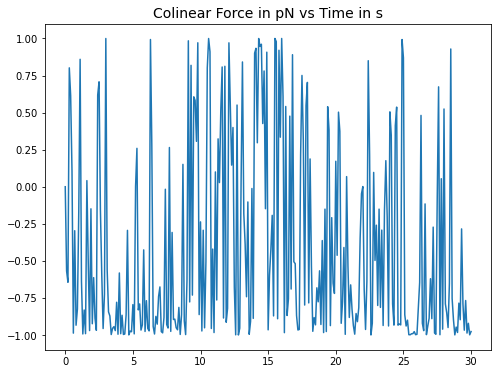

In [14]:
# Colinear Force

plt.figure(figsize =(8,6))

plt.plot(df_analysis["id"]*frame_step,df_analysis["colin"], label = 'Colinear Force')

plt.title('Colinear Force in pN vs Time in s',size=14)
#plt.legend()
plt.show()

Though there are a lot of fluctuations and this migh be hard to interpret, how to solve that issue ?  

#### Tweezers 

In experiments, one could use an optical tweezer to measure the force depending on the position. In Cytosim, a tweezer can also be implemented as a space. One also has to confine the core in the tweezer.

```
set space tweezer
{
    shape = tweezer

}

new tweezer
{
    center = ( 0 0 )
}

set solid centrosome
{
    display = ( style=3; color=blue; )
    confine = inside, 100, tweezer
}
```


### <i> <u> Third Part - Tweezers </u> </i>

<i> Thanks to the Tweezers on can compute the force exerted on the core from its position. </i>

**Q6. Run the simulation with the config file in `example_tweezers` by using the `sim` command**

**Q7. Report the characteristic of the Aster. Do the same for the Tweezer with the following report command :**  
* `../../../bin/report space:tweezer > tweezer.txt`  

**You can check that the Aster is indeed constrained to a defined position  with `play`.**

**Q8. Use the `cytosim_analysis` package to analyze the report files and Plot interesting quantities.**


In [15]:
def cytosim_analysis_function_tweezers(path_in):
    
    # REPORT FILES

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in  + "/links.txt" #Links for the Aster

    #Tweezer
    space_file = path_in + "/tweezer.txt" #Optical Tweezer Properties
    
    #Config
    config_file = path_in + "/config.cym" #Config File

    ## A PASSER DANS METHODS

    def read_space(space_set, reports=None):

            if reports is not None:
                keys = reports.keys()
                if 'space' in keys:
                    #this is too long yes...
                    with open(space_file) as f:
                        lines = [line.split() for line in f if (line[0] != '%')]
                        lines = [line for line in lines if (len(line)!= 0)]
                        lines = [line for line in lines if line[0] != 'tweezer']
                        lines = np.resize(lines,(len(lines)//3,3))

                    for row in lines:
                        space_set.append(Object(position=row[0]))
    # DICTIONNARY

    #Solid
    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    #Space
    spaces = {"space": space_file}
    space_opts = {"read": read_space}
    
    # RUN SIMUL
    
    simul = ana.Simulation(space_report = {"tweezer":spaces},
                           space_options = space_opts, 
                           solid_report={"core": solids},
                           solid_options=solid_opts,
                           config=config_file, dim=2)
    
    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force,
              "tweezer_distance":tweezer_distance}
    
    # ANALYSIS
    
    simul.make_analysis(frame_analyzer=analyzer)
    
    analysis=simul.frames_analysis
    
    return analysis 


In [16]:
df_analysis_tweezers = cytosim_analysis_function_tweezers(path_simu + '/pushing/example_tweezers')

/home/magid/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


In [17]:
df_analysis_tweezers

id  distance     colin         total_force  tweezer_distance
0      0  6.000000 -0.970143   [0.0004, -0.0001]               0.0
1      1  0.013265  0.999978  [-4.9896, -4.1924]               0.0
2      2  0.007543 -0.879444  [-0.7048, -1.7154]               0.0
3      3  0.010214  0.671344   [2.4183, -4.2619]               0.0
4      4  0.008698  0.730956    [2.3241, 4.0956]               0.0
..   ...       ...       ...                 ...               ...
496  496  0.022223  0.960247  [-1.6902, -6.9702]               0.0
497  497  0.006239 -0.754253  [-0.8907, -0.4603]               0.0
498  498  0.019234  0.556228   [-1.1129, 5.4092]               0.0
499  499  0.004300  0.979021   [-4.3036, 0.8957]               0.0
500  500  0.000600 -0.840895    [0.4222, -0.656]               0.0

[501 rows x 5 columns]

In [18]:
# PLOT

fig, axs = plt.subplots(2, 2, figsize = (12,10))

axs[0, 0].plot(df_analysis_tweezers["id"]*frame_step, np.array(df_analysis_tweezers['distance'].to_list()))
axs[0, 0].set_title('Position of the Aster in µm vs Time in s')

axs[0, 1].plot(df_analysis_tweezers["id"]*frame_step, df_analysis_tweezers["colin"])
axs[0, 1].set_title('Total Colin Force - pN vs Time in s')

axs[1, 0].plot(df_analysis_tweezers["id"]*frame_step, np.array(df_analysis_tweezers['total_force'].to_list())[:,0])
axs[1, 0].set_title('Total Force in pN - Along X axis vs Time in s')

axs[1, 1].plot(df_analysis_tweezers["id"]*frame_step, np.array(df_analysis_tweezers['total_force'].to_list())[:,1])
axs[1, 1].set_title('Total Force in pN - Along Y axis vs Time in s')


plt.show()

Now that we have seen that we can contrain the position of the Aster with a Tweezer, we would like to probe preciseley the Force-Position relationship by computing the force for a wide range of position of the Tweezer.  

To do so, we will use configuration templates and work in the `pushing_tweezers` directory with template `config_tpl.cym`:


``` 
[[ x = [-9 + i for i in range(19)]]]

set space tweezer
{
    shape = tweezer

}

new tweezer
{
    center = ( [[x]] 0 )
}
```

### <i> <u> Fourth Part - Pushing - Force vs Position </u> </i>

Thanks to the Tweezers we can get the force vs position curve.

**Q9. Follow these steps to generate config files, run simulations and report stuff**  

* Generate config files

  `../../../python/run/preconfig.py config_tpl.cym`
  

* Place in separated directories

  `mkdir files`  
  `mv config_tpl*.cym ./files`
  
  
* Run simulations

  `../../../python/run/go_sim.py ../../../bin/sim ./files/config_tpl*.cym njobs=10`
  
  
* Report stuff

 `../../../python/look/scan.py '/need absolute path here/bin/report aster:force > force.txt' run0* njobs=10 `  
 `../../../python/look/scan.py '/need absolute path here/bin/report aster:links > links.txt' run0* njobs=10 `  
 `../../../python/look/scan.py '/need absolute path here/bin/report space:tweezer > tweezer.txt' run0* njobs=10 `

**Q10. Loop over the runs and use `cytosim_analysis` to extract Force and Position**  

In [28]:
#Analyzing Loop

assigned_tweezer = [ -9 + i for i in range(19)]

analysis_list = []

path_pushing = path_simu + '/pushing/pushing_tweezers/'

runs = np.sort(os.listdir(path_pushing))[1:]

for run in runs:
    print(run)
    analysis_list.append(cytosim_analysis_function_tweezers(path_pushing + run))
    

run0000


/home/magid/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


run0001


run0002


run0003


run0004


run0005


run0006


run0007


run0008


run0009


run0010


run0011


run0012


run0013


run0014


run0015


run0016


run0017


run0018


run0019


AttributeError: 'list' object has no attribute 'words'

In [29]:
#Extract Data Frames 

df_distance = pd.DataFrame([anali['distance'] for anali in analysis_list]).transpose()
df_distance.columns = assigned_tweezer 

df_total_force= pd.DataFrame([anali['total_force'] for anali in analysis_list]).transpose()
df_total_force.columns = assigned_tweezer 

df_colin = pd.DataFrame([anali['distance'] for anali in analysis_list]).transpose()
df_colin.columns = assigned_tweezer 

df_tweezer_distance = pd.DataFrame([anali['tweezer_distance'] for anali in analysis_list]).transpose()
df_tweezer_distance.columns = assigned_tweezer 

**Q11. Plot the Force along X as a function of the Assigned Position of the Tweezers**

In [30]:
#TOTAL FORCE ON X AND Y 

total_force_X = []

for u in df_total_force.columns:
    total_force_X.append([df_total_force[u][i][0] for i in df_total_force.index])


total_force_X = np.array(total_force_X)
    
df_total_force_X = pd.DataFrame(total_force_X).transpose()
df_total_force_X.columns = assigned_tweezer 


total_force_Y = []

for u in df_total_force.columns:
    total_force_Y.append([df_total_force[u][i][1] for i in df_total_force.index])


total_force_Y = np.array(total_force_Y)
    
df_total_force_Y = pd.DataFrame(total_force_Y).transpose()
df_total_force_Y.columns = assigned_tweezer 

In [31]:
tresh = 200 #Treshold for which we start considering the mean

df_total_force_X_mean = df_total_force_X[df_total_force_X.index > tresh].mean()
df_total_force_X_std = df_total_force_X[df_total_force_X.index > tresh].std() 

df_distance_mean = df_distance[df_distance.index > 200].mean()

df_total_force_X_sdem = df_distance_mean/np.sqrt(len(df_total_force_X) - tresh)

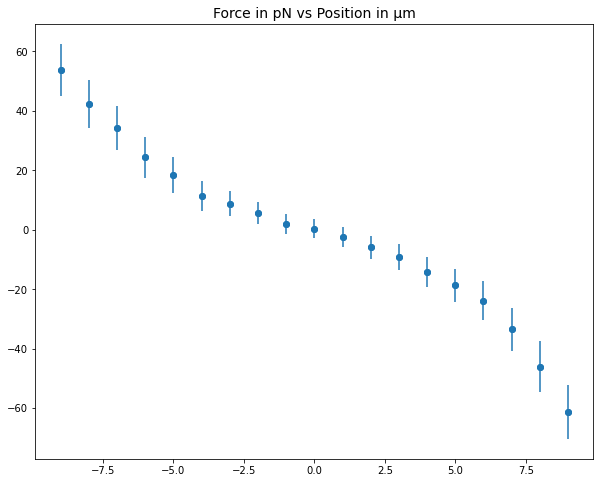

In [32]:
#PLOT FORCE VS POSITION

plt.figure(figsize = (10,8))

plt.scatter(assigned_tweezer,df_total_force_X_mean)
plt.errorbar(assigned_tweezer, df_total_force_X_mean, yerr=df_total_force_X_std, fmt='o')
plt.title("Force in pN vs Position in µm",size = 14)
plt.show()

### <i> <u> EXTRA - Fifth Part - Force vs Microtubule Length </u> </i>

We can also exploit the previous data trying to etablish the link between the Force and the Length of the Microtubule.  

**Q12. Report fibers properties**

In [128]:
def individual_force(frame):
    return frame.objects["solid"]["core"][0].fiber_forces[:,3:5]
 
def length_microtubule(frame):
    return frame.objects['fiber']['microtubule'][0].points[:,1]

def cytosim_analysis_function_tweezers_indiv(path_in):

    ## A PASSER DANS METHODS

    def read_space(space_set, reports=None):

            if reports is not None:
                keys = reports.keys()
                if 'space' in keys:
                    #this is too long yes...
                    with open(space_file) as f:
                        lines = [line.split() for line in f if (line[0] != '%')]
                        lines = [line for line in lines if (len(line)!= 0)]
                        lines = [line for line in lines if line[0] != 'tweezer']
                        lines = np.resize(lines,(len(lines)//3,3))

                    for row in lines:
                        space_set.append(Object(position=row[0]))
    
    ## REPORT FILES

    #Fibers
    fibers_file = path_in + "/fibers.txt" #Microtubule

    #Aster
    solid_file = path_in + "/force.txt" #Force for the Aster
    link_file = path_in  + "/links.txt" #Links for the Aster

    #Tweezer
    space_file = path_in + "/tweezers.txt" #Optical Tweezer Properties 

    #Config
    config_file = path_in + "/config.cym" #Config File


    solids =   {"force": solid_file, "link": link_file}
    solid_opts = {"type" : "solid" , "set" : Aster_set}

    spaces = {"space": space_file}
    space_opts = {"read": read_space}

    microtubule_reports = {"points" : fibers_file}

    simul = ana.Simulation(fibers_report = {"microtubule" : microtubule_reports},
                           solid_report={"core": solids},
                           space_report = {"tweezer":spaces},
                           space_options = space_opts, 
                           solid_options=solid_opts,
                           config = config_file,dim=2)   
    # ANALYSIS FUNCTION DECLARATION

    analyzer={"distance": distance, 
              "colin": colin , 
              "total_force":total_force,
              "tweezer_distance":tweezer_distance,
              "length_microtubule":length_microtubule,
              "individual_force": individual_force}
    
    # ANALYSIS
    
    simul.make_analysis(frame_analyzer=analyzer)
    
    analysis=simul.frames_analysis
    
    return simul, analysis 


simul, df_analysis = cytosim_analysis_function_tweezers_indiv(path_simu + '/pushing/example_tweezers')

In [129]:
len(df_analysis['length_microtubule'][100])

50

In [130]:
len(df_analysis['individual_force'][100])

50

**Q13. We also would like to plot the individual force as a function of the length of the microtubule**  

In [131]:
radius_aster = 0.5
radius_cell = 10

In [132]:
df_force_length= pd.concat(
                [pd.DataFrame({'length' : df_analysis['length_microtubule'][i], 
              'force' : np.linalg.norm(df_analysis['individual_force'][i],axis=1)}) 
                 for i in df_analysis.index ])

In [133]:
df_analysis

id  distance     colin         total_force  tweezer_distance  \
0      0  6.000000 -0.970143   [0.0004, -0.0001]               0.0   
1      1  0.013265  0.999978  [-4.9896, -4.1924]               0.0   
2      2  0.007543 -0.879444  [-0.7048, -1.7154]               0.0   
3      3  0.010214  0.671344   [2.4183, -4.2619]               0.0   
4      4  0.008698  0.730956    [2.3241, 4.0956]               0.0   
..   ...       ...       ...                 ...               ...   
496  496  0.022223  0.960247  [-1.6902, -6.9702]               0.0   
497  497  0.006239 -0.754253  [-0.8907, -0.4603]               0.0   
498  498  0.019234  0.556228   [-1.1129, 5.4092]               0.0   
499  499  0.004300  0.979021   [-4.3036, 0.8957]               0.0   
500  500  0.000600 -0.840895    [0.4222, -0.656]               0.0   

                                    length_microtubule  \
0    [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
1    [2.8453, 0.7408, 1.0133, 1.3163, 2.8205, 2.818...   
2    [3.6696, 0.5008, 0.7589, 1.9082, 3.6654, 3.674...   
3    [4.5287, 1.3536, 1.602, 2.749, 4.5001, 4.5109,...   
4    [5.3801, 2.1722, 0.5102, 3.5843, 5.354, 5.3568...   
..                                                 ...   
496  [3.3559, 7.876, 7.3264, 7.0209, 10.0281, 4.228...   
497  [4.1747, 8.7217, 6.0627, 7.8237, 10.0102, 5.06...   
498  [5.0389, 9.5421, 5.7117, 8.6817, 8.0653, 5.933...   
499  [2.462, 8.7753, 6.5633, 6.9166, 8.278, 6.7533,...   
500  [2.8229, 5.7753, 6.3449, 7.0523, 9.1016, 7.61,...   

                                      individual_force  
0    [[-0.0, 0.0], [0.0004, -0.0], [-0.0003, 0.0], ...  
1    [[0.7507, -0.4067], [-0.2409, -0.2216], [-0.35...  
2    [[0.2088, -1.042], [0.072, -0.0067], [0.4098, ...  
3    [[0.1232, -0.2965], [0.0331, 0.3726], [0.1934,...  
4    [[-0.6615, -0.2371], [0.5332, 0.1494], [0.044,...  
..                                                 ...  
496  [[0.0918, -0.4932], [-0.5651, -0.4087], [0.303...  
497  [[-0.4274, -0.3353], [-1.3928, -0.0806], [1.72...  
498  [[-0.9703, -0.0292], [0.2353, -0.7508], [-0.55...  
499  [[-0.9159, -0.1483], [0.8401, -0.1437], [0.501...  
500  [[0.064, 0.01], [-0.1928, 0.2861], [0.7051, -1...  

[501 rows x 7 columns]

In [134]:
df_force_length_filtered = df_force_length[df_force_length.length > (radius_cell - radius_aster)]

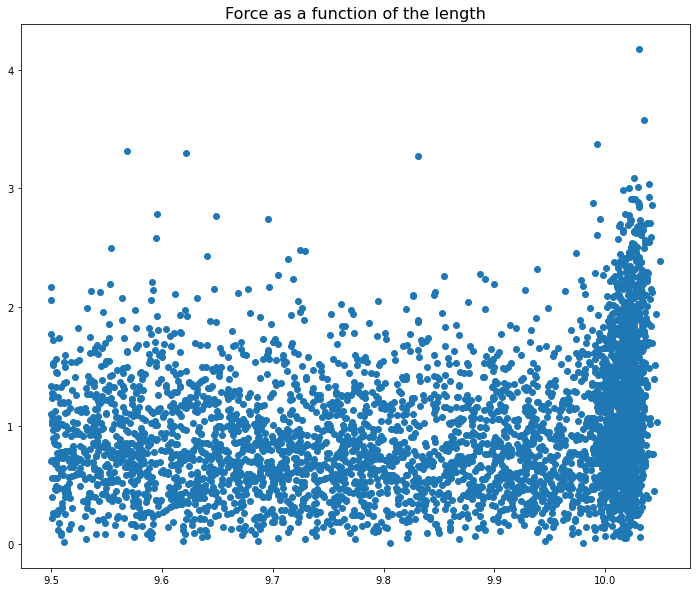

In [135]:
plt.figure(figsize = (12,10))

plt.scatter(df_force_length_filtered['length'].to_numpy(), df_force_length_filtered['force'].to_numpy())

plt.title("Force as a function of the length", size = 16)
plt.show()